<a id='top'></a>

# Contents

[final figures](#figures)

[load datasets](#load datasets)

[shuffleSplit lasso](#shufflesplit)

[CV lasso](#cv)

[bootstap lasso](#bootstrap)

[create histogram of selected features](#histogram)

[train lasso](#lasso)

[train multi-layer perceptron (MLP) regressor](#nn)

In [9]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import itertools as it
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from numpy.random import randint
from __future__ import print_function
import numpy.linalg as LINA
from sklearn.preprocessing import StandardScaler
import os
import sys
from itertools import cycle
from collections import OrderedDict
%matplotlib inline

plt.rc("figure", facecolor="white")

#grab our checkName code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import salty

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 24,
    'font.size': 24,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
    'axes.titlesize': 28
   }
plt.rcParams.update(params)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
lines = ["-","--","-."]
marker = ['o','s','8','p','D','^']#,'8','s', '+', '.', 'o', '*'
linecycler = cycle(lines)
markercycler = cycle(marker)

def myround(x, base):
    return (float(base) * round(float(x)/float(base)))

salts=pd.read_csv('../salty/data/density.csv',delimiter=',')
salts.columns

Index([u'Unnamed: 0', u'Molar volume, m<SUP>3</SUP>/mol', u'Pressure, kPa',
       u'Specific density, kg/m<SUP>3</SUP>',
       u'Specific volume, m<SUP>3</SUP>/kg', u'Temperature, K', u'salt_name'],
      dtype='object')

/home/wesley/anaconda3/envs/py27/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from IPython.kernel.zmq import kernelapp as app


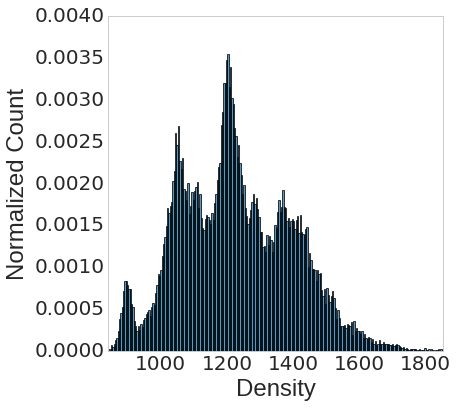

In [33]:
df=salts["Specific density, kg/m<SUP>3</SUP>"]
df = df.convert_objects(convert_numeric=True)
df.dropna(inplace=True)
df = df.loc[df >= 1.0]
fig=plt.figure(figsize=(6,6), dpi=300)
    

###histogram of viscosity distribution
with plt.style.context('seaborn-whitegrid'):
    ax = fig.add_subplot(111)
    ax.hist(df, bins=250, normed=True, alpha=0.75, color=tableau20[0])
    plt.xlabel('Density')
    plt.ylabel('Normalized Count')
    plt.axis([df.min(), df.max(), 0, 0.004])
    plt.grid(False)
    plt.show()
fig.savefig(filename='../webapp/salty_web_app/collection/static/images/density_hist.png', bbox_inches='tight', format='png') 

<a id='figures'></a>

# Final figures

[back to top](#top)

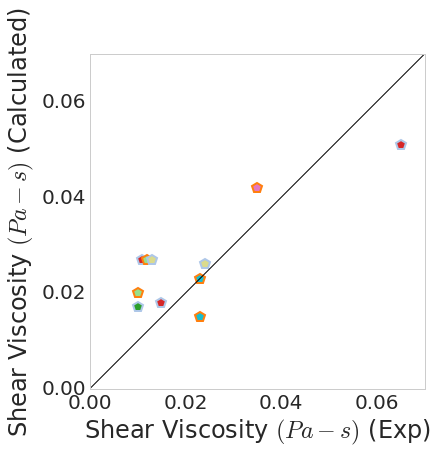

In [49]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax = fig.add_subplot(111)
    df=pd.read_csv('combinedviscosity.csv', header=0)
    ##################
    #START PLOTTING VISCOSITIES
    ##################
    k=0
    for i,p in enumerate(df[['cation']].values): 

        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        try:


            if catIndex > 20 & aniIndex > 20:
                ax.plot(myround(df[['viscosity_exp_350']].values[i][0], 0.001)\
                    ,myround(df[['viscosity_maginn_einstein']].values[i][0], 0.001)\
                    , linestyle='-', marker="s",color = tableau20[aniIndex%20],\
                        markeredgecolor = tableau20[catIndex%20], mew='2', label=name)
            elif catIndex < 20 & aniIndex > 20:
                ax.plot(myround(df[['viscosity_exp_350']].values[i][0], 0.001)\
                    ,myround(df[['viscosity_maginn_einstein']].values[i][0], 0.001)\
                    , linestyle='-', marker="o",color = tableau20[aniIndex%20],\
                        markeredgecolor = tableau20[catIndex%20], mew='2', label=name)
            elif catIndex > 20 & aniIndex < 20:
                ax.plot(myround(df[['viscosity_exp_350']].values[i][0], 0.001)\
                    ,myround(df[['viscosity_maginn_einstein']].values[i][0], 0.001)\
                    , linestyle='-', marker="8",color = tableau20[aniIndex%20],\
                        markeredgecolor = tableau20[catIndex%20], mew='2', label=name)
            elif catIndex < 20 & aniIndex < 20:
                ax.plot(myround(df[['viscosity_exp_350']].values[i][0], 0.001)\
                    ,myround(df[['viscosity_maginn_einstein']].values[i][0], 0.001)\
                    , linestyle='-', marker="p",color = tableau20[aniIndex%20],\
                        markeredgecolor = tableau20[catIndex%20], mew='2', label=name)

    #         plt.legend(bbox_to_anchor=[1.6,.99]) 
            k=k+1
        except ValueError:
            pass
    ax.plot(np.arange(0,0.07,0.0001),np.arange(0,0.07,0.0001),color = 'black')
    ##################
    #MAKE PLOT ADJUSTMENTS
    ##################
#     plt.rc
    #ax.set_xlim(0.01,0.05)
    #ax.set_ylim(0.01,0.05)
    ax.set_yticks(np.arange(0.0,0.08,0.02))
    ax.set_xticks(np.arange(0.0,0.08,0.02))
    ax.set_xlabel('Shear Viscosity $(Pa-s)$ (Exp)')
    ax.set_ylabel('Shear Viscosity $(Pa-s)$ (Calculated)')
    plt.grid(False)
    fig.subplots_adjust(wspace=.4)
    fig.savefig(filename='maginn.eps', bbox_inches='tight', format='eps') 

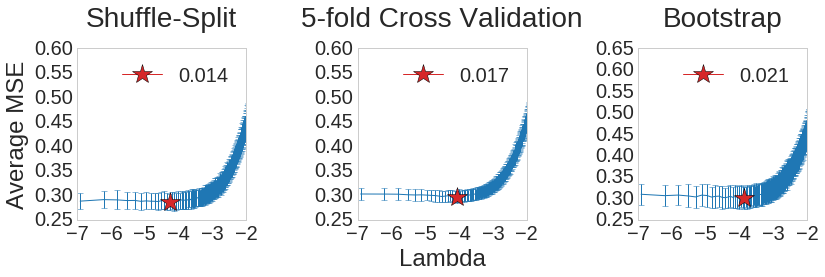

In [3]:
shuffleaverages = np.load("shuffleSplitSmallAlphasAverages.npy")
shufflevariances = np.load("shuffleSplitSmallAlphasVariances.npy")
cvaverages = np.load("CVSmallAlphasAverages.npy")
cvvariances = np.load("CVSmallAlphasVariances.npy")
bootstrapaverages = np.load("BootstrapSmallAlphasAverages.npy")
bootstrapvariances = np.load("BootstrapSmallAlphasVariances.npy")
alpha_array = np.arange(0.2,0,-1e-3)

with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(12,4.5), dpi=300)
    ax1 = fig.add_subplot(131)
    optimum_alpha=alpha_array[np.argmin(np.absolute(shuffleaverages))]
    plt.errorbar(np.log(alpha_array), np.absolute(shuffleaverages), np.absolute(shufflevariances),\
        c=tableau20[0])
    plt.plot(np.log(optimum_alpha), np.min(np.absolute(shuffleaverages)), \
        c=tableau20[6], marker='*', markersize=20, label=optimum_alpha)
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(False)
    plt.ylabel('Average MSE')
    plt.xlim(-7,-2)
    plt.title('Shuffle-Split', y=1.1)
    ax2 = fig.add_subplot(132)
    optimum_alpha=alpha_array[np.argmin(np.absolute(cvaverages))]
    plt.errorbar(np.log(alpha_array), np.absolute(cvaverages), np.absolute(cvvariances),\
        c=tableau20[0])
    plt.plot(np.log(optimum_alpha), np.min(np.absolute(cvaverages)), \
        c=tableau20[6], marker='*', markersize=20, label=optimum_alpha)
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(False)
    plt.xlabel('Lambda')
    plt.xlim(-7,-2)
    plt.title('5-fold Cross Validation', y=1.1)
    ax3 = fig.add_subplot(133)
    optimum_alpha=alpha_array[np.argmin(np.absolute(bootstrapaverages))]
    plt.errorbar(np.log(alpha_array), np.absolute(bootstrapaverages), np.absolute(bootstrapvariances),\
        c=tableau20[0])
    plt.plot(np.log(optimum_alpha), np.min(np.absolute(bootstrapaverages)), \
        c=tableau20[6], marker='*', markersize=20, label=optimum_alpha)
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(False)
    plt.xlim(-7,-2)
    plt.title('Bootstrap', y=1.1)
    plt.tight_layout()
fig.savefig(filename='poster_images/lassoParam.eps', bbox_inches='tight', format='eps')  

<a id='load datasets'></a>

# Load datasets

[back to top](#top)

## P < 200 V < 1

In [14]:
###Load scaled and centered data with 1/T**2, T**2, and logT feature and cation/anion names
###0-452 coco salts
###453-660 unknown cation/anion
###661-1303 unknown cation
###1304-1359 unknown anion

datadf = pd.read_pickle('visc_master_centered_scaled_alltemps_smallP_lowV_withnames')
datadf = datadf.reset_index(drop=True)
# datadf = datadf.iloc[:453,:]
datadf = datadf.sample(frac=1).reset_index(drop=True)

anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

In [14]:
###Load scaled and centered data with 1/T**2, T**2, and logT feature and cation/anion names
###0-452 coco salts
###453-660 unknown cation/anion
###661-1303 unknown cation
###1304-1359 unknown anion

datadf = pd.read_pickle('visc_master_centered_scaled_alltemps_withnames')
datadf = datadf.reset_index(drop=True)
datadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 

datadf = datadf.iloc[:453,:].sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

## Same as above, with different selection from same data pickle

In [48]:
###Load scaled and centered data with 1/T**2, T**2, and logT feature and cation/anion names
###0-452 coco salts
###453-660 unknown cation/anion
###661-1303 unknown cation
###1304-1359 unknown anion

datadf = pd.read_pickle('visc_centered_scaled_alltemps_withnames')
datadf = datadf.reset_index(drop=True)
datadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 

datadf = datadf.iloc[:,:].sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

## From orginal dataset

In [2]:
###Load scaled and centered data with 1/T**2, T**2, and logT feature
datadf = pd.read_pickle('visc_centered_scaled_alltemps')
datadf = datadf.sample(frac=1).reset_index(drop=True)

# datadf = datadf.drop('1/T',1)
data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

<a id='shufflesplit'></a>

# Shuffle split LASSO

[back to top](#top)

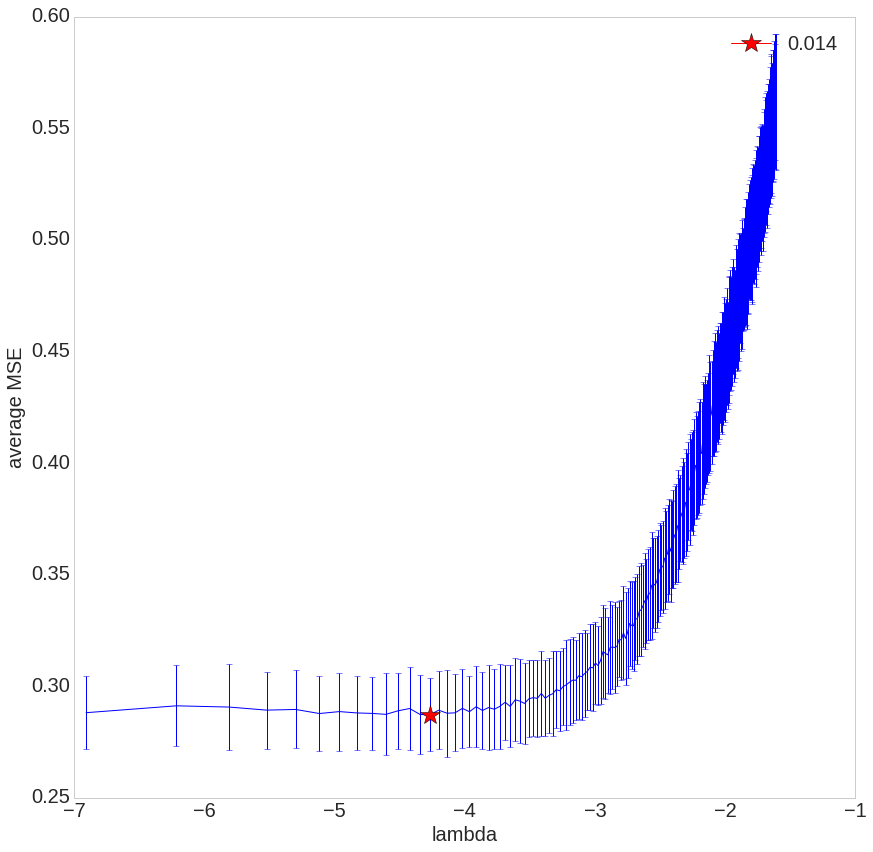

In [3]:
averages = np.load("shuffleSplitSmallAlphasAverages.npy")
variances = np.load("shuffleSplitSmallAlphasVariances.npy")
alpha_array = np.arange(0.2,0,-1e-3)
salty.displayResult(alpha_array, averages, variances=variances, error=True)

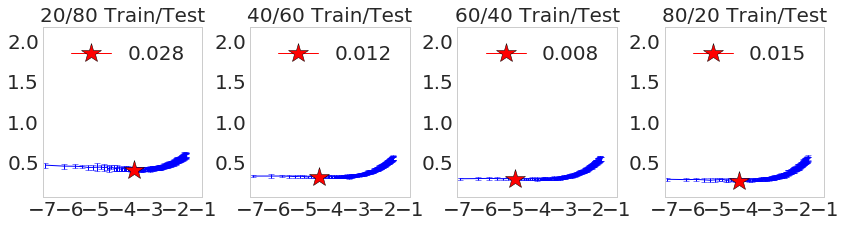

In [29]:
averages=np.load("bootstrap_smallalphas_averages.npy")
variances=np.load("bootstrap_smallalphas_variances.npy")
alpha_array=np.arange(0.2,0,-1e-3)
iterations=30
to_test=[0.2, 0.4, 0.6, 0.8]
fig=plt.figure(figsize=(14,14), dpi=300)
k=1

for j in range(len(to_test)):
    with plt.style.context('seaborn-whitegrid'):
        optimum_alpha=alpha_array[np.argmin(averages[j,:])]
        ax = fig.add_subplot(4,4,k)
        ax.errorbar(np.log(alpha_array), averages[j,:], variances[j,:])
        ax.plot(np.log(optimum_alpha), np.min(averages[j,:]), \
            c='r', marker='*', markersize=20, label=optimum_alpha)
        plt.title('%s/%s Train/Test' % (int((to_test[j]*100)),100-int((to_test[j]*100))),\
                 size=20)
        plt.ylim(0.1,2.2)
        plt.legend()
        ax.grid(False)
        k+=1
plt.subplots_adjust(wspace=0.3) 
plt.show()

In [42]:
###for bootstrap with invisible test
alpha_array=np.arange(1,0,-1e-2)
iterations=30
to_test=[0.2, 0.4, 0.6, 0.8]
averages=np.zeros(((len(to_test),len(to_test),len(alpha_array))))
variances=np.zeros(((len(to_test),len(to_test),len(alpha_array))))

for i in range(len(to_test)):
    for j in range(len(to_test)):
        avg, std, results = shuffleSplitWrapper(name_of_pickle="visc_centered_scaled", \
                TSF=to_test[i], SSF=to_test[j], alpha_array=alpha_array, iterations=\
                iterations, invisible_test=True)
        averages[i,j,:] = avg
        variances[i,j,:] = std

Job will perform 100 tests for lambda
Job 0 % complete
Job 10 % complete
Job 20 % complete
Job 30 % complete
Job 40 % complete
Job 50 % complete
Job 60 % complete
Job 70 % complete
Job 80 % complete
Job 90 % complete
Job complete, optimum lambda converged on 0.09
Job will perform 100 tests for lambda
Job 0 % complete
Job 10 % complete
Job 20 % complete
Job 30 % complete
Job 40 % complete
Job 50 % complete
Job 60 % complete
Job 70 % complete
Job 80 % complete
Job 90 % complete
Job complete, optimum lambda converged on 0.08
Job will perform 100 tests for lambda
Job 0 % complete
Job 10 % complete
Job 20 % complete
Job 30 % complete
Job 40 % complete
Job 50 % complete
Job 60 % complete
Job 70 % complete
Job 80 % complete
Job 90 % complete
Job complete, optimum lambda converged on 0.12
Job will perform 100 tests for lambda
Job 0 % complete
Job 10 % complete
Job 20 % complete
Job 30 % complete
Job 40 % complete
Job 50 % complete
Job 60 % complete
Job 70 % complete
Job 80 % complete
Job 90 % 

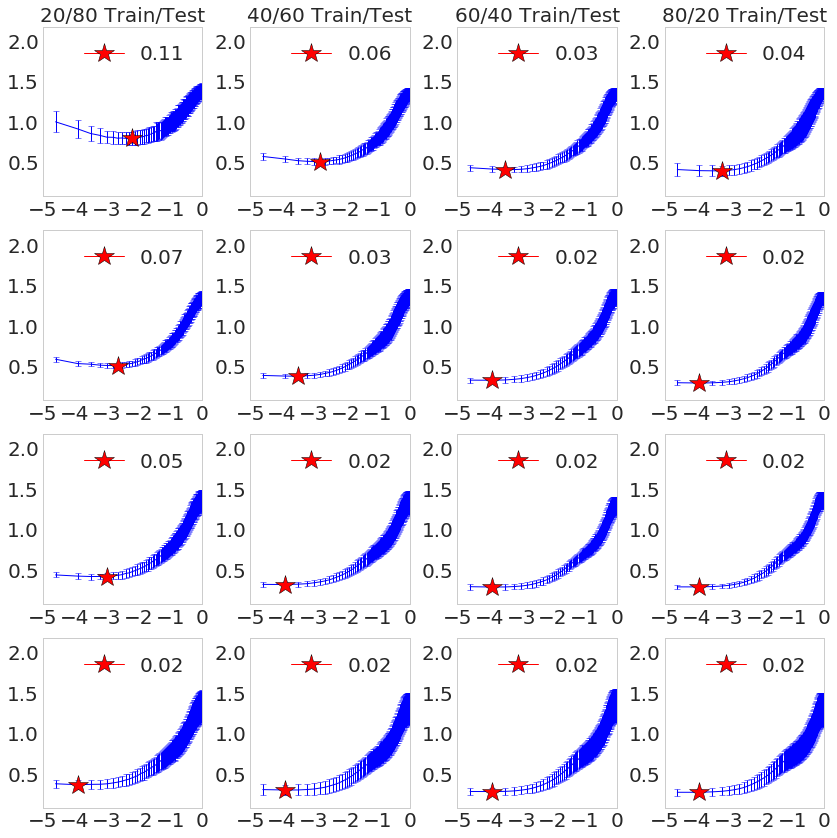

In [113]:
averages=np.load("bootstrap_averages.npy")
variances=np.load("bootstrap_variances.npy")
alpha_array=np.arange(1,0,-1e-2)
iterations=2
to_test=[0.2, 0.4, 0.6, 0.8]
fig=plt.figure(figsize=(14,14), dpi=300)
k=1
for i in range(len(to_test)):
    for j in range(len(to_test)):
        with plt.style.context('seaborn-whitegrid'):
            optimum_alpha=alpha_array[np.argmin(averages[i,j,:])]
            ax = fig.add_subplot(4,4,k)
            ax.errorbar(np.log(alpha_array), averages[i,j,:], variances[i,j,:])
            if j == 0:
                ax.set_xlabel=("test")#'%s%% Reserved for Bootstrap' % int((to_test[j]*100)))
            ax.plot(np.log(optimum_alpha), np.min(averages[i,j,:]), \
                c='r', marker='*', markersize=20, label=optimum_alpha)
            if i == 0:
                plt.title('%s/%s Train/Test' % (int((to_test[j]*100)),100-int((to_test[j]*100))),\
                    size=20)
                
            
                
                
            plt.ylim(0.1,2.2)  
            plt.legend()
            ax.grid(False)
            k+=1

plt.subplots_adjust(wspace=0.3) 
plt.savefig(filename="test.png")
plt.show()


<a id='cv'></a>

# CV Lasso

[back to top](#top)

[scikit-learn](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

"When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV" 

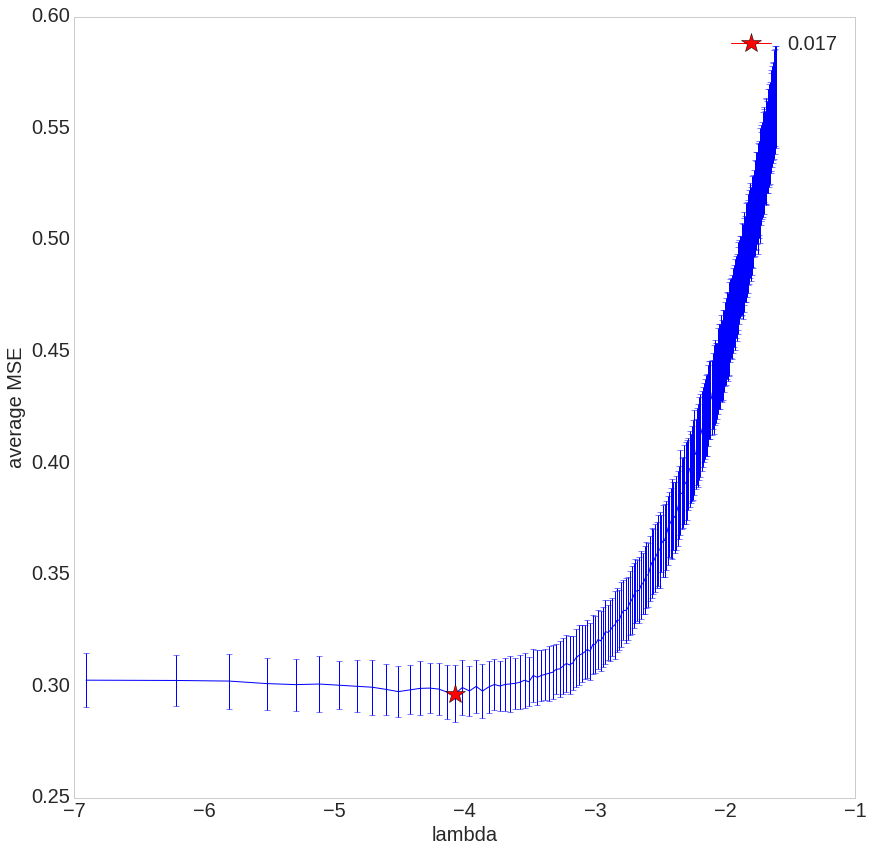

In [2]:
averages = np.load("CVSmallAlphasAverages.npy")
variances = np.load("CVSmallAlphasVariances.npy")
alpha_array = np.arange(0.2,0,-1e-3)
salty.displayResult(alpha_array, averages, variances=variances, error=True)

Job will perform 5000 tests for lambda
Job 0 % complete
Job 10 % complete
Job 20 % complete
Job 30 % complete
Job 40 % complete
Job 50 % complete
Job 60 % complete
Job 70 % complete
Job 80 % complete
Job 90 % complete
Job 100 % complete
Job 110 % complete
Job 120 % complete
Job 130 % complete
Job 140 % complete
Job 150 % complete
Job 160 % complete
Job 170 % complete
Job 180 % complete
Job 190 % complete
Job 200 % complete
Job 210 % complete
Job 220 % complete
Job 230 % complete
Job 240 % complete
Job 250 % complete
Job 260 % complete
Job 270 % complete
Job 280 % complete
Job 290 % complete
Job 300 % complete
Job 310 % complete
Job 320 % complete
Job 330 % complete
Job 340 % complete
Job 350 % complete
Job 360 % complete
Job 370 % complete
Job 380 % complete
Job 390 % complete
Job 400 % complete
Job 410 % complete
Job 420 % complete
Job 430 % complete
Job 440 % complete
Job 450 % complete
Job 460 % complete
Job 470 % complete
Job 480 % complete
Job 490 % complete
Job 500 % complete
Job

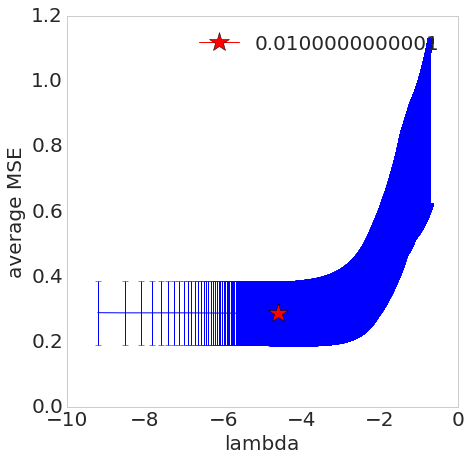

31 BertzCTcation
120 LogPcation
160 Mnccation
288 bcutp10cation
304 bcutv10cation
396 CIC4anion
397 CIC5anion
435 GATSe3anion
485 LogP2anion
498 MATSm5anion
499 MATSm6anion
523 MRVSA5anion
542 PEOEVSA12anion
547 PEOEVSA6anion
589 SIC4anion
736 petitjeantanion
744 slogPVSA4anion
748 T
749 P
19 total features selected
Job complete


(array([-0.88012575, -0.88002422, -0.8799227 , ..., -0.28843441,
        -0.28865916, -0.28917592]),
 array([ 0.25388372,  0.2538574 ,  0.25383108, ...,  0.09847915,
         0.09848611,  0.09841864]),
 array([  5.00000000e-01,   4.99900000e-01,   4.99800000e-01, ...,
          3.00000000e-04,   2.00000000e-04,   1.00000000e-04]))

In [74]:
CVLasso(datadf, alpha_array=np.arange(0.5,0,-1e-4), wrapper=False)

In [21]:
###Train the LASSO model
alpha_array=np.arange(0.5,0,-1e-3)
averages=np.zeros(len(alpha_array))
variances=np.zeros(len(alpha_array))

for i in range(len(alpha_array)):
    model = Lasso(alpha=alpha_array[i],tol=1e-10)
    scores = cross_val_score(model, X_train, Y_train, cv=20, scoring='neg_mean_squared_error')
    avg = np.average(scores)
    std = np.std(scores)
    averages[i] = avg
    variances[i] = std

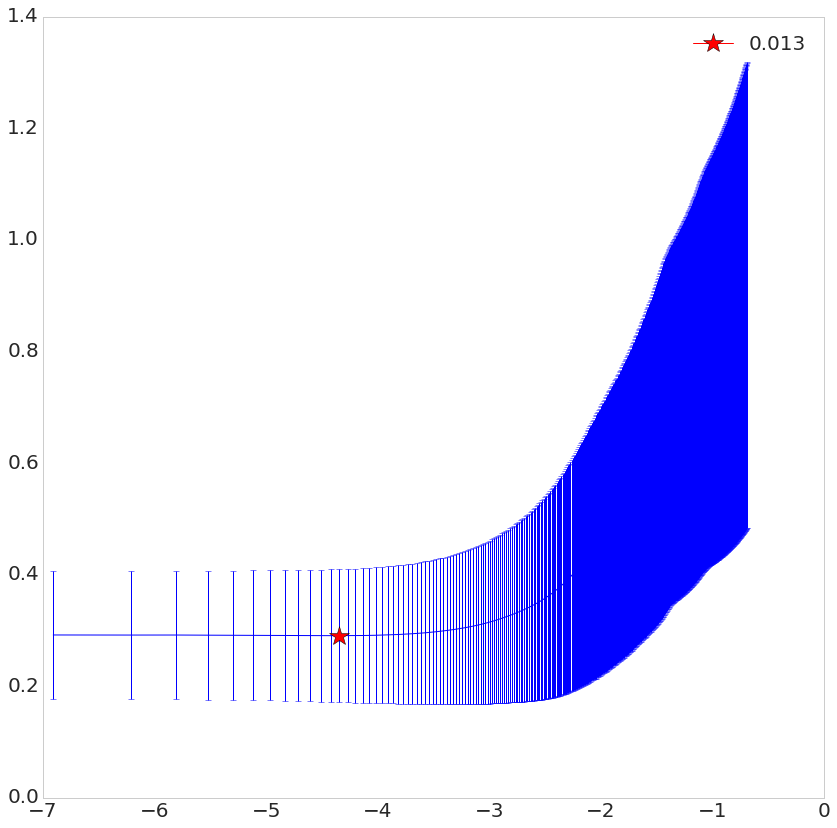

<a id='bootstrap'></a>

# Bootstrap LASSO

[back to top](#top)

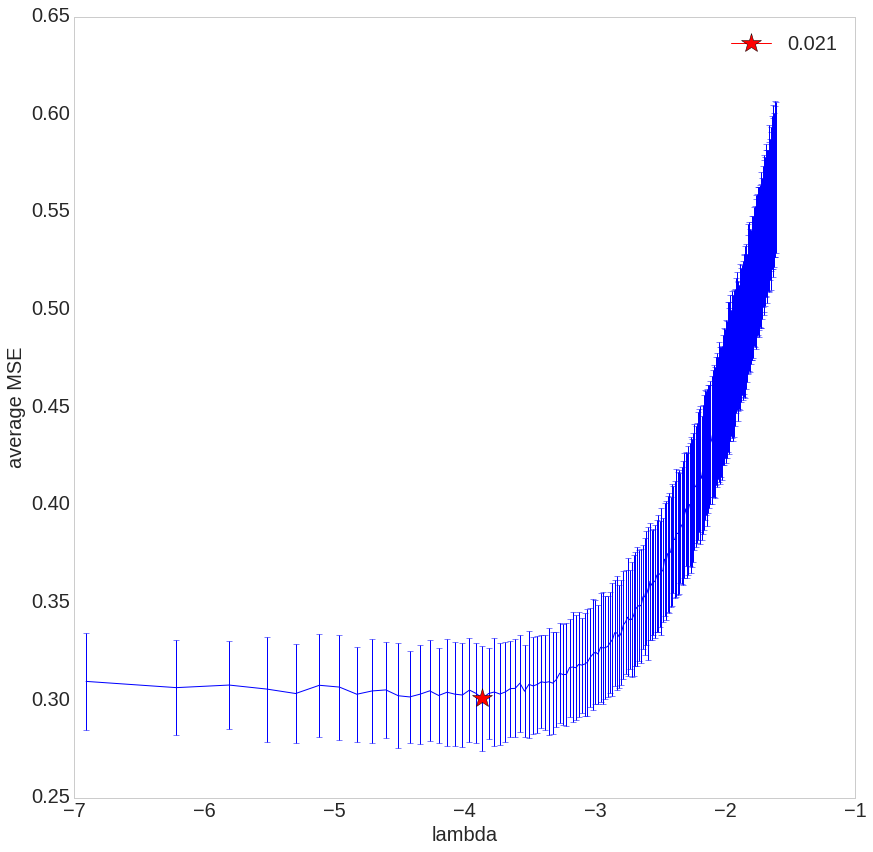

In [9]:
averages = np.load("BootstrapSmallAlphasAverages.npy")
variances = np.load("BootstrapSmallAlphasVariances.npy")
alpha_array = np.arange(0.2,0,-1e-3)
salty.displayResult(alpha_array, averages, variances=variances, error=True)

In [15]:
###for bootstrap with invisible test
alpha_array=np.arange(1,0,-1e-1)
iterations=3
to_test=[0.2, 0.4, 0.6, 0.8]
averages=np.zeros(((len(to_test),len(to_test),len(alpha_array))))
variances=np.zeros(((len(to_test),len(to_test),len(alpha_array))))

for i in range(len(to_test)):
    for j in range(len(to_test)):
        avg, std, results = validationWrapper(name_of_pickle="visc_centered_scaled", \
                TSF=to_test[i], BSF=to_test[j], alpha_array=alpha_array, iterations=\
                iterations, invisible_test=True)
        averages[i,j,:] = avg
        variances[i,j,:] = std

performing iteration 1 of 3
Job will perform 10 tests for lambda with 0.2 reserved for validation and 0.2 test set
Job 0 % complete
Job complete, optimum lambda converged on 0.1
performing iteration 2 of 3
Job will perform 10 tests for lambda with 0.2 reserved for validation and 0.2 test set
Job 0 % complete
Job complete, optimum lambda converged on 0.1
performing iteration 3 of 3
Job will perform 10 tests for lambda with 0.2 reserved for validation and 0.2 test set
Job 0 % complete
Job complete, optimum lambda converged on 0.4
performing iteration 1 of 3
Job will perform 10 tests for lambda with 0.2 reserved for validation and 0.4 test set
Job 0 % complete
Job complete, optimum lambda converged on 0.1
performing iteration 2 of 3
Job will perform 10 tests for lambda with 0.2 reserved for validation and 0.4 test set
Job 0 % complete
Job complete, optimum lambda converged on 0.1
performing iteration 3 of 3
Job will perform 10 tests for lambda with 0.2 reserved for validation and 0.4 test

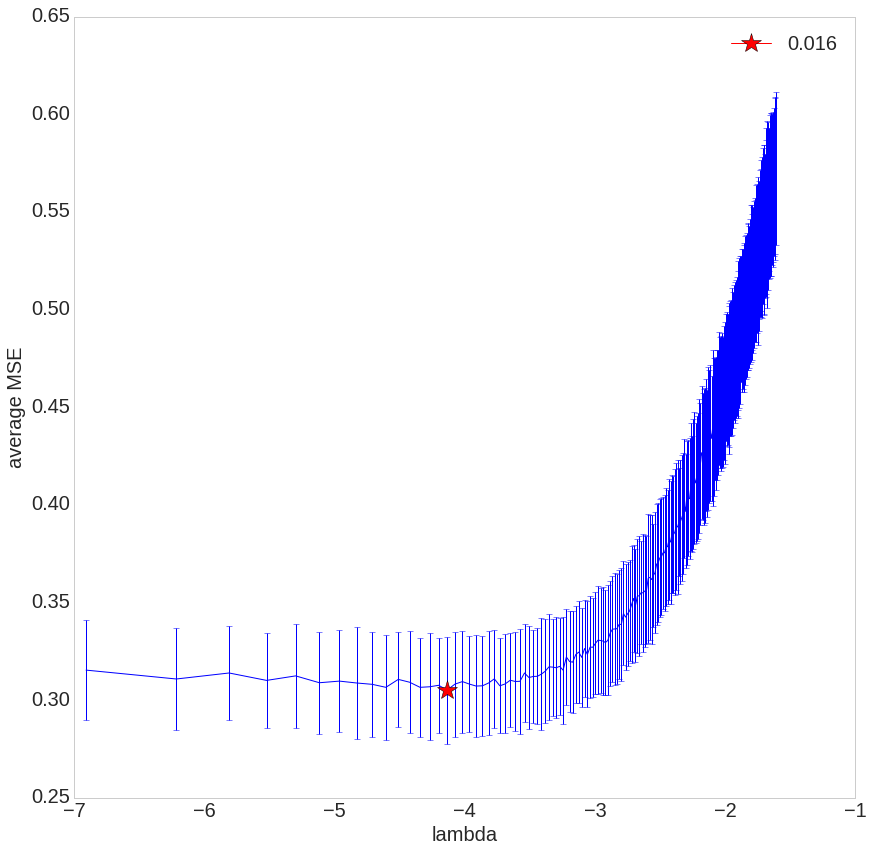

In [8]:
averages=np.load("BootstrapSmallAlphasAverages.npy")
variances=np.load("BootstrapSmallAlphasVariances.npy")
alpha_array=np.arange(0.2,0,-1e-3)
displayResult(alpha_array, averages=averages, variances=variances, error=True)

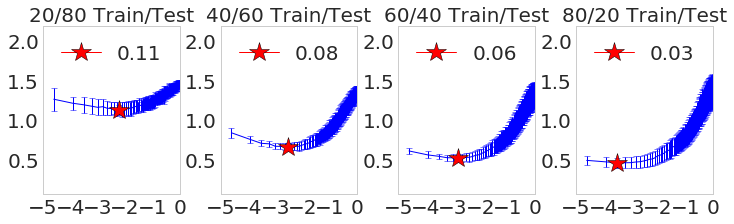

In [17]:
averages=np.load("BootstrapSmallMultipleAverages.npy")
variances=np.load("BootstrapSmallMultipleVariances.npy")
alpha_array=np.arange(1,0,-1e-2)
iterations=30
to_test=[0.2, 0.4, 0.6, 0.8]
fig=plt.figure(figsize=(12,3), dpi=300)
k=1
for i in range(len(to_test)):
    for j in range(len(to_test)-3):
        with plt.style.context('seaborn-whitegrid'):
            optimum_alpha=alpha_array[np.argmin(averages[i,j,:])]
            ax = fig.add_subplot(1,4,k)
            ax.errorbar(np.log(alpha_array), averages[i,j,:], variances[i,j,:])
            if j == 0:
                ax.set_xlabel=("test")#'%s%% Reserved for Bootstrap' % int((to_test[j]*100)))
            ax.plot(np.log(optimum_alpha), np.min(averages[i,j,:]), \
                c='r', marker='*', markersize=20, label=optimum_alpha)
            plt.title('%s/%s Train/Test' % (int((to_test[i]*100)),100-int((to_test[i]*100))),\
                size=20)
#             if i == 0:
#             ax.ylabel("Average MSE")
                
            
                
                
            plt.ylim(0.1,2.2)  
            plt.legend()
            ax.grid(False)
            k+=1

plt.subplots_adjust(wspace=0.3) 
plt.savefig(filename="bootstrap_train_test_splits.png")
plt.show()

<a id='histogram'></a>

# Create histogram of selected features using optimized LASSO

[back to top](#top)

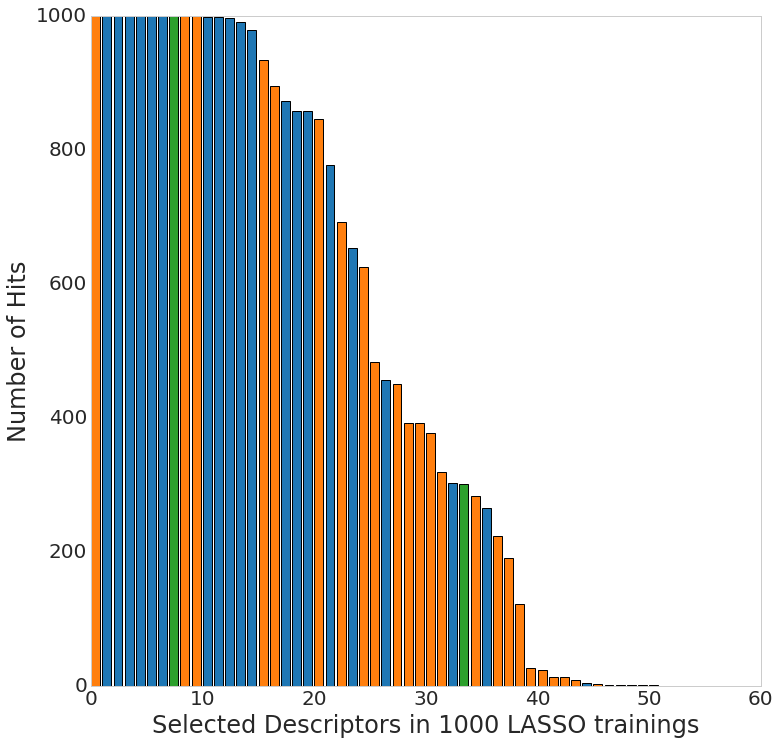

In [11]:
select_score = np.load("LASSOSelectionScores.npy")
select_deslist = np.load("LASSOSelectionList.npy")
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False)
fig=plt.figure(figsize=(12,12), dpi=300)
colors=[]
for i in range(len(df)):
    try:
        if df.index[i].split("-")[1] == "anion":
            colors.append(tableau20[0])
        else:
            colors.append(tableau20[2])
    except:
        colors.append(tableau20[4]) #logT and P will throw-off assignment

with plt.style.context('seaborn-whitegrid'):
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(select_score)),df.iloc[:][0],label=select_deslist,color=colors)
    plt.grid(False)
    plt.xlabel('Selected Descriptors in 1000 LASSO trainings')
    plt.ylabel('Number of Hits')
fig.savefig(filename='poster_images/largeHistogram.eps', bbox_inches='tight', format='eps')   

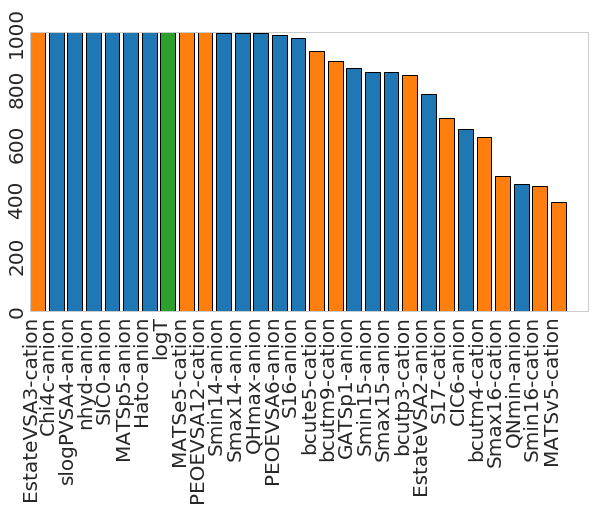

In [13]:
fig=plt.figure(figsize=(10,5), dpi=300)
avg_selected_features=29

colors=[]
for i in range(len(df[:avg_selected_features])):
    try:
        if df.index[i].split("-")[1] == "anion":
            colors.append(tableau20[0])
        else:
            colors.append(tableau20[2])
    except:
        colors.append(tableau20[4]) #logT and P will throw-off assignment

with plt.style.context('seaborn-whitegrid'):
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(select_score[:avg_selected_features])),df.iloc[:avg_selected_features]\
           [0],tick_label=df.iloc[:avg_selected_features].index,color=colors)
    ax.set_xticklabels( df.iloc[:avg_selected_features].index, rotation=90 )
    ax.set_yticklabels([0,200,400,600,800,1000],rotation=90)
    plt.grid(False)
fig.savefig(filename='poster_images/smallHistogram.eps', bbox_inches='tight', format='eps')   

In [22]:
if df.index[1].split("-")[1] == "anion":
    print("anion")

anion


In [7]:
###Load scaled and centered data
datadf = pd.read_pickle('visc_centered_scaled_alltemps')
data=np.array(datadf)
deslist=datadf.columns
score=np.zeros(len(datadf.columns))
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train
for i in range(1000):
    data = np.random.permutation(data) #if you delete, will not be random ie separate by group
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = np.log(data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1].astype(float))

    ###Train the LASSO model
    model = Lasso(alpha=0.016,tol=1e-10,max_iter=2000)
    model.fit(X_train,Y_train)

    ###Check what features are selected
    i=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            i+=1
    avg_size.append(i)
print(np.average(avg_size))
select_score=[]
select_deslist=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])

<a id='lasso'></a>

# Train LASSO

[back to top](#top)

In [16]:
###Train the LASSO model
model = Lasso(alpha=0.021,tol=1e-10,max_iter=4000)
model.fit(X_train,Y_train)

Lasso(alpha=0.021, copy_X=True, fit_intercept=True, max_iter=4000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-10, warm_start=False)

In [17]:
###Check what features are selected
i=0
for a in range(len(data[0])-1):
    if model.coef_[a] != 0:
        print(a,datadf.columns[a])
        i+=1
print(i)

67 EstateVSA3-cation
125 MATSe5-cation
171 PEOEVSA12-cation
265 bcute5-cation
285 bcutm9-cation
289 bcutp12-cation
295 bcutp3-cation
400 Chi4c-anion
422 EstateVSA2-anion
461 Hato-anion
500 MATSp5-anion
538 PEOEVSA6-anion
544 QHmax-anion
547 QNmax-anion
558 S16-anion
570 SIC0-anion
586 Smax14-anion
587 Smax15-anion
601 Smin14-anion
602 Smin15-anion
710 nhyd-anion
711 nnitro-anion
727 slogPVSA4-anion
734 logT
24


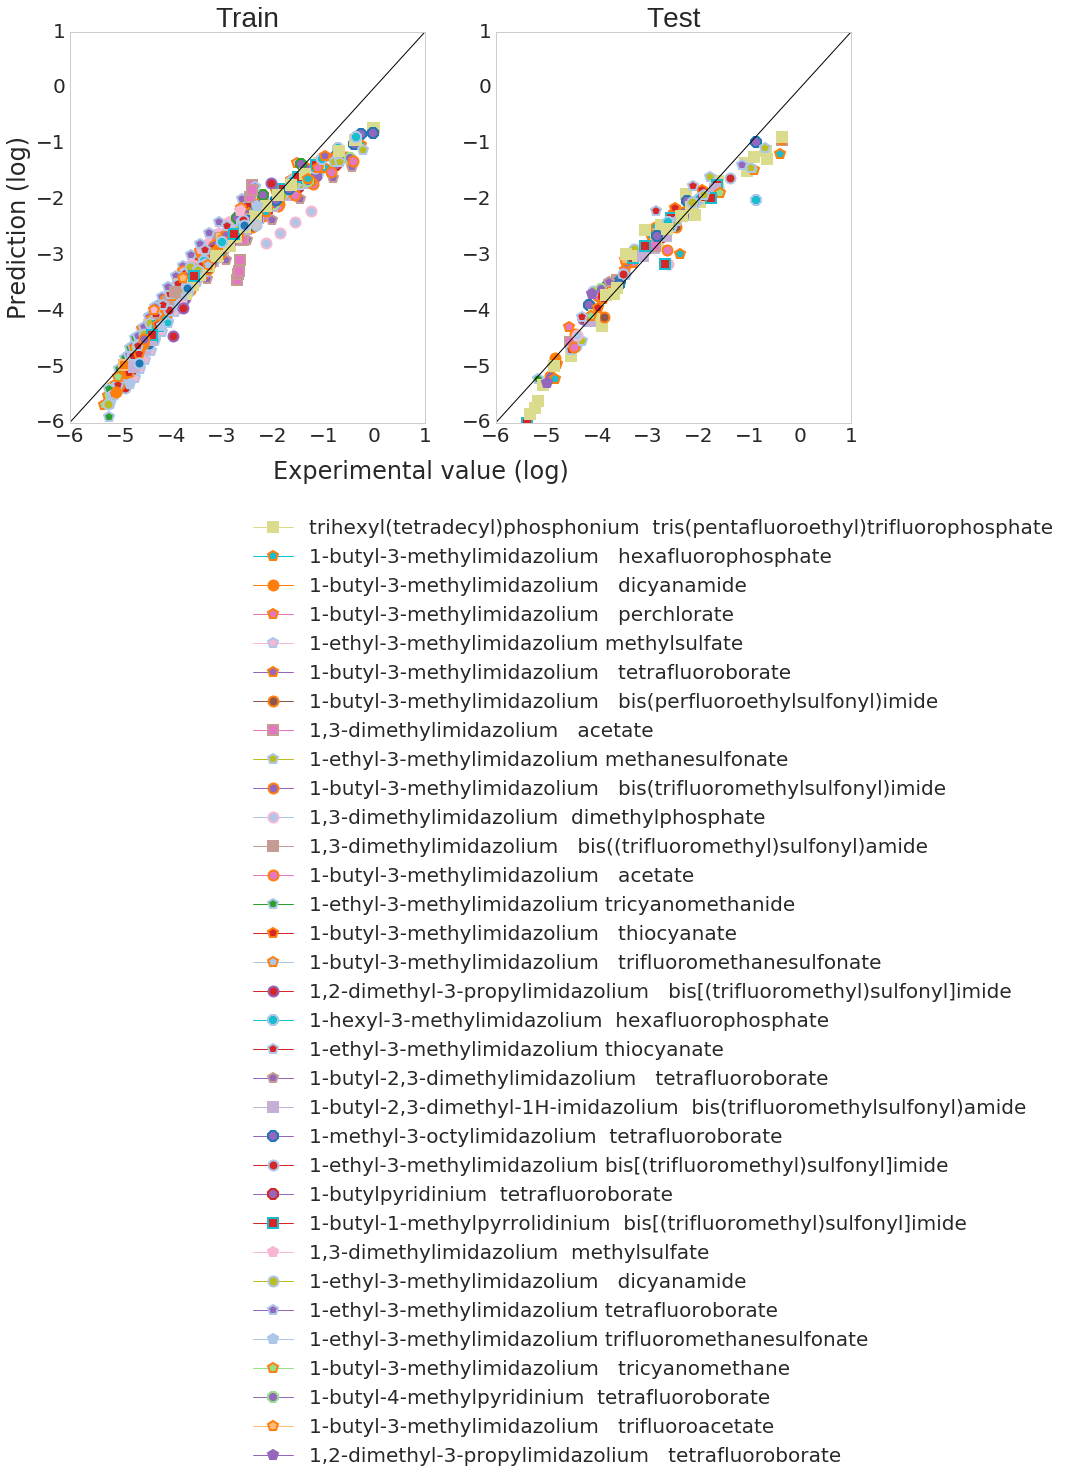

In [18]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(14,7), dpi=300)
    ax = fig.add_subplot(121)
    labels=[]
    colors=[]
    shapes=[]
    edge_colors=[]
    check=[]
    scatter=[]
    for i in range(len(X_train)):
        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
    for i in range(len(X_train)):
        ax.plot(Y_train[i],model.predict(X_train[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])        
    ax.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax.axis([-6,1,-6,1])

    plt.text(-2,-7,'Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(122)
    labels=[]
    colors=[]
    shapes=[]
    edge_colors=[]
    check=[]
    scatter=[]
    for i in range(len(X_test)):
        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax2.axis([-6,1,-6,1])
    plt.title('Test')
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()
fig.savefig(filename='LassoRegression.eps', bbox_inches='tight', format='eps')    

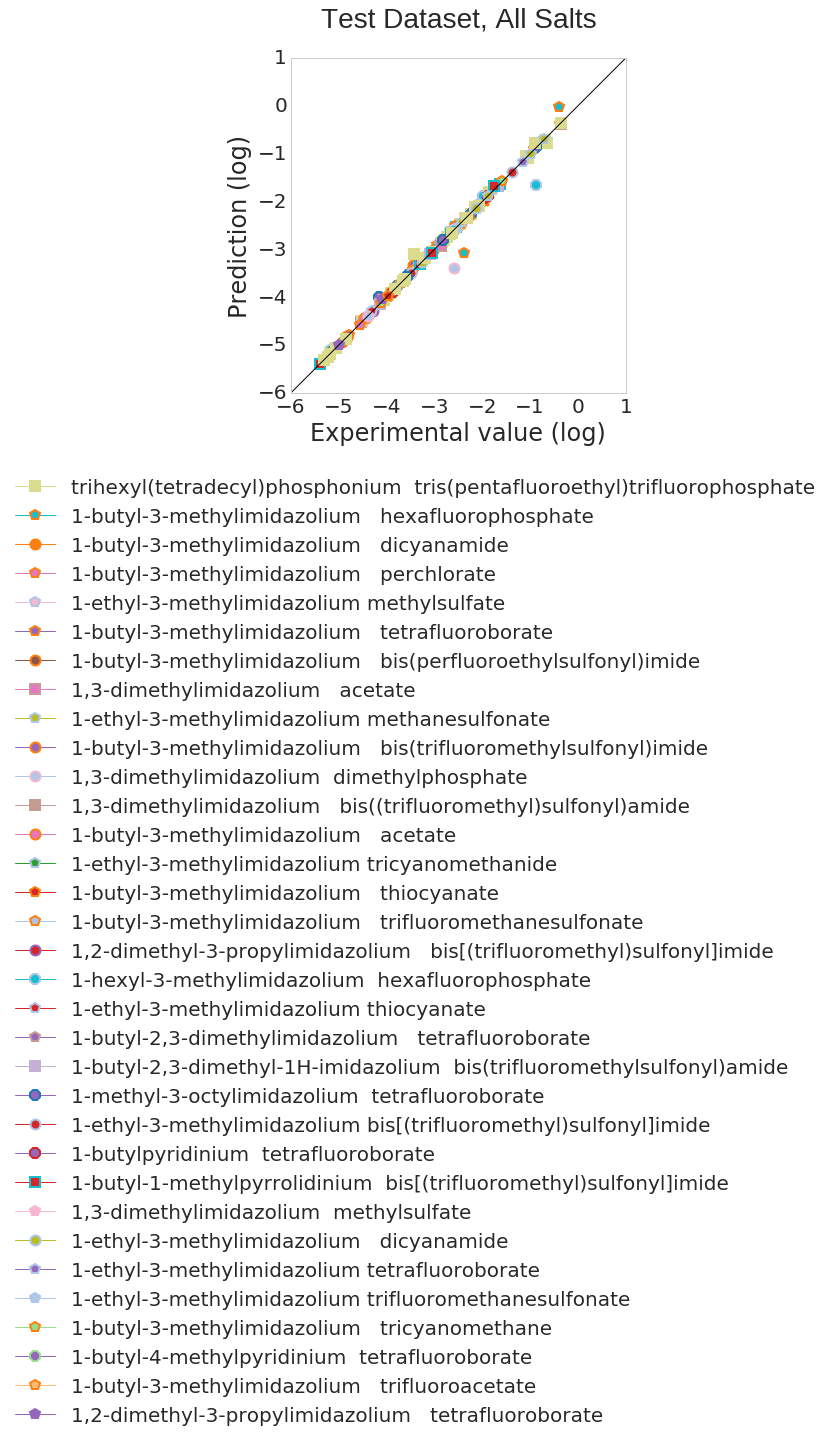

In [33]:
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_test)):
        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax2.axis([-6,1,-6,1])
    plt.title('Test Dataset, All Salts', y=1.08)
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()
    
    
    
#     figlegend = pylab.figure(figsize=(3,2))
#     ax = fig.add_subplot(111)
#     lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
#     figlegend.legend(lines, ('one', 'two'), 'center')
#     fig.show()
#     figlegend.show()
# fig.savefig('legend.png')

fig.savefig(filename='poster_images/legend.pdf', bbox_inches='tight', format='pdf')    

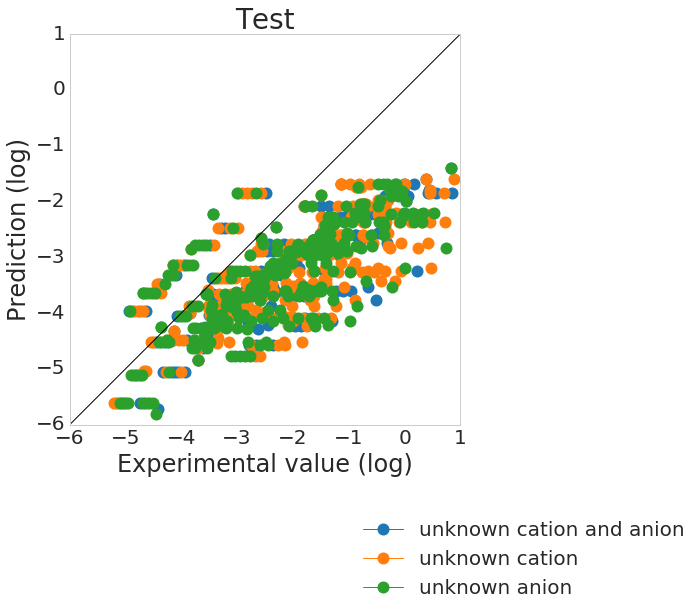

In [15]:
###Load scaled and centered data with 1/T**2, T**2, and logT feature and cation/anion names
###0-190 unknown cation/anion (190)
###190-566 unknown cation (376)
###566-621 unknown anion (55)
import sys
import mpld3
reload(sys)
sys.setdefaultencoding("utf-8")
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(7,7), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Validation')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_test)):
        if i < 190:
            name = str("unknown cation and anion")
            colors.append(tableau20[0])
            edge_colors.append(tableau20[0])
        elif i < 566:
            name = str("unknown cation")
            colors.append(tableau20[2])
            edge_colors.append(tableau20[2])
        else:
            name = str("unknown anion")
            colors.append(tableau20[4])
            edge_colors.append(tableau20[4])
            
        shapes.append("o")
        labels.append(name)  
    
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax2.axis([-6,1,-6,1])
    plt.title('Test')
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

In [20]:
###optimization w/ 100 nodes in hidden layer
model = MLPRegressor(activation='tanh', alpha=0.1993933915059608, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

model.fit(X_train,Y_train)

MLPRegressor(activation='tanh', alpha=0.199393391506, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=1000000000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)

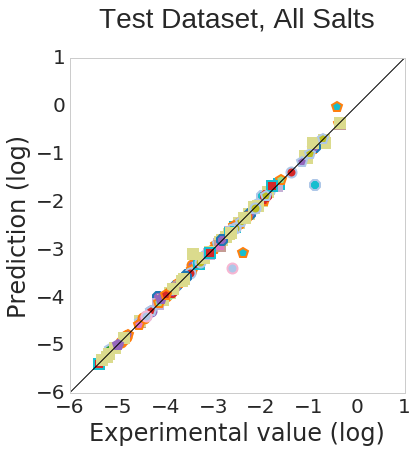

In [21]:
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_test)):
        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax2.axis([-6,1,-6,1])
    plt.title('Test Dataset, All Salts', y=1.08)
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()

fig.savefig(filename='poster_images/NN_Test_Dataset_All_Salts.eps', bbox_inches='tight', format='eps')    

[back to top](#top)

In [ ]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(14,7), dpi=300)
    ax = fig.add_subplot(121)
    labels=[]
    colors=[]
    shapes=[]
    edge_colors=[]
    check=[]
    scatter=[]
    for i in range(len(X_train)):
        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
    for i in range(len(X_train)):
        ax.plot(Y_train[i],model.predict(X_train[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])        
    ax.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax.axis([-6,1,-6,1])

    plt.text(-2,-7,'Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(122)
    labels=[]
    colors=[]
    shapes=[]
    edge_colors=[]
    check=[]
    scatter=[]
    for i in range(len(X_test)):
        catIndex = checkName(catlist[i],index=True)[1]
        aniIndex = checkName(anilist[i],index=True)[1]
        name = str("%s %s" % (catlist[i], anilist[i]))
        labels.append(name)
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax2.axis([-6,1,-6,1])
    plt.title('Test')
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()
fig.savefig(filename='LassoRegression.eps', bbox_inches='tight', format='eps')    

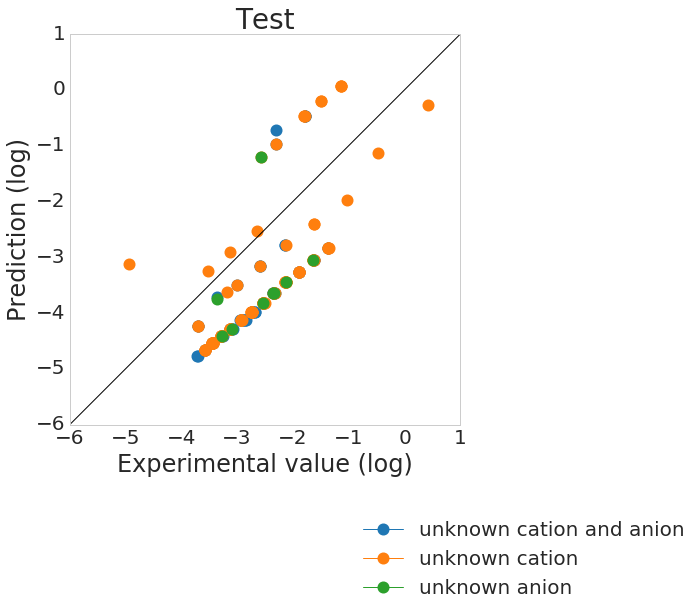

In [131]:
###Load scaled and centered data with 1/T**2, T**2, and logT feature and cation/anion names
###0-190 unknown cation/anion (190)
###190-566 unknown cation (376)
###566-621 unknown anion (55)
import sys
import mpld3
reload(sys)
sys.setdefaultencoding("utf-8")
labels=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]

with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(7,7), dpi=300)
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Validation')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    
    for i in range(len(X_test)):
        if i < 190:
            name = str("unknown cation and anion")
            colors.append(tableau20[0])
            edge_colors.append(tableau20[0])
        elif i < 566:
            name = str("unknown cation")
            colors.append(tableau20[2])
            edge_colors.append(tableau20[2])
        else:
            name = str("unknown anion")
            colors.append(tableau20[4])
            edge_colors.append(tableau20[4])
            
        shapes.append("o")
        labels.append(name)  
    
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    ax2.axis([-6,1,-6,1])
    plt.title('Test')
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,-0.2))
    plt.show()